## Should we normalise our data before training model?

Note: the classes are heavily imbalanced so we should repeat these experiments with a more balanced dataset(?)

In [1]:
import numpy as np
import mne
from tqdm import tqdm
from ARMA import ARMA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, auc, precision_recall_curve, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
def load_EEG(filepath, label) -> (np.ndarray, np.ndarray):
    if label == 'preictal':
        data = np.load(filepath)
        target = np.ones(data.shape[1])
    if label == 'interictal':
        data = mne.io \
        .read_raw_edf(input_fname=filepath, preload=False, verbose='Error') \
        .get_data(picks='all', units='uV', return_times=False)
        target = -1
    return data, target

In [3]:
root = '/Volumes/My Passport/AI_Research/data/physionet.org/files/chbmit/1.0.0/' 
case = 'chb01/'
preictal_filenames = ['chb01_03_preictal.npy', 'chb01_04_preictal.npy', 'chb01_15_preictal.npy', 'chb01_16_preictal.npy',
             'chb01_18_preictal.npy', 'chb01_26_preictal.npy']
interictal_filenames = ['chb01_01.edf', 'chb01_02.edf', 'chb01_05.edf',
                        'chb01_06.edf', 'chb01_07.edf', 'chb01_08.edf']

In [4]:
# ARMA parameters
seed = 42
fs = 256                 # sampling frequency (Hz)
N = 512                  # fs = N*fp (N must be a natural number)
fp = fs/N                # prediction frequency
n_i = 2                  # AR model order
t_s = 1/fs               # Input signal time period
n_c = 23                 # Number of EEG electrodes (channels)
m = 30                   # MA parameter
print(f'Input channels: {n_c}')
print(f'Model: AR({n_i})')
print(f'MA lookback: {m}')
print(f'Window size: {N}')
print(f'Sampling frequency: {fs} Hz')
print(f'Prediction frequency: {fp} Hz')
ar = ARMA(window_width=N, order=n_i, memory=m, seed=seed)

Input channels: 23
Model: AR(2)
MA lookback: 30
Window size: 512
Sampling frequency: 256 Hz
Prediction frequency: 0.5 Hz


In [5]:
# load preictal and interictal data
preictal_data_list = []
preictal_feature_list = []

interictal_data_list = []
interictal_feature_list = []
for i in range(6):
    # load preictal data
    p_filepath = root + case + preictal_filenames[i]
    p_data, p_target = load_EEG(p_filepath, 'preictal')
    # generate preictal features
    _, _, preictal_features = ar.spin(sig=p_data, fs=256)
    # load interictal data
    ic_filepath = root + case + interictal_filenames[i]
    ic_data, ic_target = load_EEG(ic_filepath, 'interictal')
    # generate interictal features
    _, _, interictal_features = ar.spin(sig=ic_data, fs=256)
    
    # store data in list
    preictal_data_list.append(p_data)
    preictal_feature_list.append(preictal_features)
    
    interictal_data_list.append(ic_data)
    interictal_feature_list.append(interictal_features)

100%|██████████| 921086/921086 [00:06<00:00, 133222.50it/s]


Our prediction signal classified the preictal and interictal period with low confidence. We investigate why.

(449,) (449,)


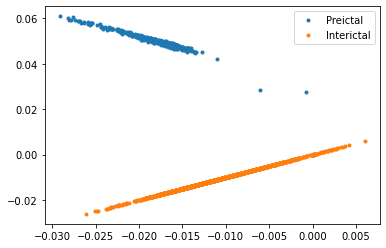

In [6]:
x1 = preictal_feature_list[0][:,0,0]
x2 = preictal_feature_list[0][:,0,1]
print(x1.shape, x2.shape)

x3 = interictal_feature_list[0][:,0,0]
x4 = interictal_feature_list[0][:,0,0]

plt.figure()
plt.plot(x1, x2, '.', label='Preictal')
plt.plot(x3, x4, '.', label='Interictal')
plt.legend()
plt.show()

In [7]:
df = pd.DataFrame(preictal_feature_list[0][:,0,:], columns=['Feature 1', 'Feature 2'])
df['Interval'] = 'Preictal'
df_2 = pd.DataFrame(interictal_feature_list[0][:,0,:], columns=['Feature 1', 'Feature 2'])
df_2['Interval'] = 'Interictal'
frames = [df, df_2]
rdf = pd.concat(frames)
rdf

,Feature 1,Feature 2,Interval
0,0.000000,0.000000,Preictal
1,0.000000,0.000000,Preictal
2,0.000000,0.000000,Preictal
3,0.000000,0.000000,Preictal
4,0.000000,0.000000,Preictal
...,...,...,...
1793,-0.017676,0.041922,Interictal
1794,-0.015273,0.045847,Interictal
1795,-0.017282,0.050132,Interictal
1796,-0.005795,0.034950,Interictal


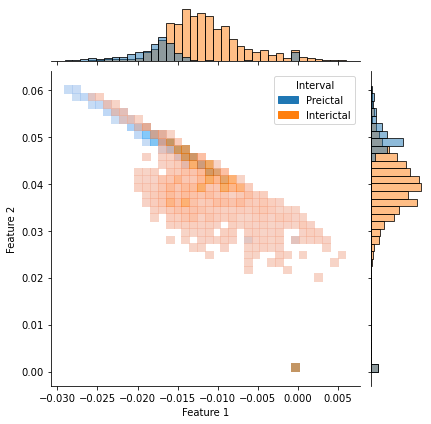

In [8]:
# visualise distribution
sns.jointplot(data=rdf, x='Feature 1', y='Feature 2', hue='Interval', kind='hist', alpha=0.6)
plt.show()

Classification on raw data.

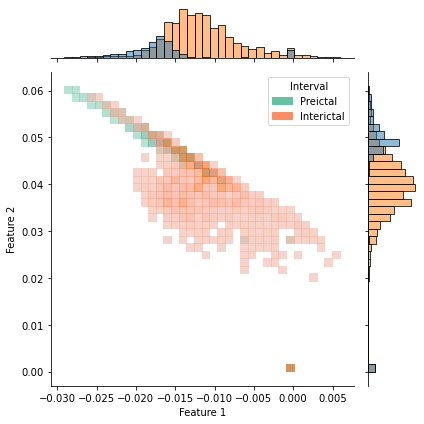

In [9]:
# visualise distribution
palette = sns.color_palette('Set2', n_colors=2)
sns.jointplot(data=rdf, x='Feature 1', y='Feature 2', hue='Interval', kind='hist', palette=palette, alpha=0.6)
plt.tight_layout()
plt.savefig('../figures/classification/chb01/AR_imbalanced.pdf')
plt.show()

In [10]:
X = np.concatenate((interictal_feature_list[0][:,0,:], preictal_feature_list[0][:,0,:]))
X.shape

(2247, 2)

In [11]:
interictal_targets = -1 * np.ones(interictal_feature_list[0][:,0,:].shape[0])
preictal_targets = np.ones(preictal_feature_list[0][:,0,:].shape[0])
print(interictal_targets.shape, preictal_targets.shape)
y = np.hstack((interictal_targets, preictal_targets))
y.shape

(1798,) (449,)


(2247,)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

[[186   0]
 [ 39   0]]
              precision    recall  f1-score   support

        -1.0       0.83      1.00      0.91       186
         1.0       0.00      0.00      0.00        39

    accuracy                           0.83       225
   macro avg       0.41      0.50      0.45       225
weighted avg       0.68      0.83      0.75       225



/Users/sameenislam/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


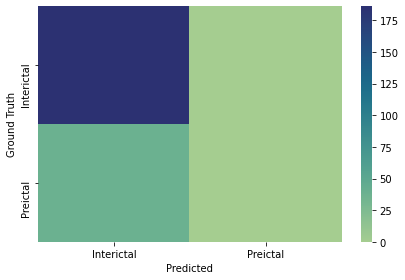

In [23]:
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
confuse = confusion_matrix(y_test, y_pred)

palette = sns.color_palette('crest', as_cmap=True)
ax = sns.heatmap(confuse, cmap=palette)
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.tight_layout()
plt.savefig('../figures/classification/chb01/AR_imbalanced_SVM_heatmap.pdf')
plt.show()

[[345  26]
 [ 24  55]]
              precision    recall  f1-score   support

        -1.0       0.93      0.93      0.93       371
         1.0       0.68      0.70      0.69        79

    accuracy                           0.89       450
   macro avg       0.81      0.81      0.81       450
weighted avg       0.89      0.89      0.89       450



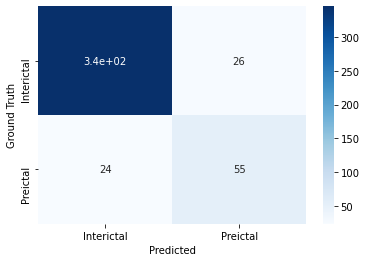

In [203]:
svc = SVC(kernel='rbf')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
confuse = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confuse, annot=True, cmap='Blues')
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.show()

[[356  15]
 [ 38  41]]
              precision    recall  f1-score   support

        -1.0       0.90      0.96      0.93       371
         1.0       0.73      0.52      0.61        79

    accuracy                           0.88       450
   macro avg       0.82      0.74      0.77       450
weighted avg       0.87      0.88      0.87       450



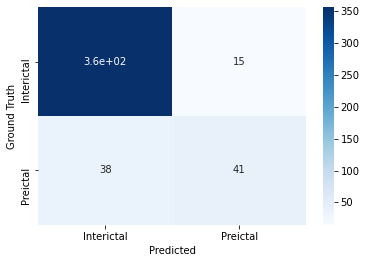

In [214]:
svc = SVC(kernel='poly', degree=3)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
confuse = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confuse, annot=True, cmap='Blues')
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.show()

[[277  94]
 [ 77   2]]
              precision    recall  f1-score   support

        -1.0       0.78      0.75      0.76       371
         1.0       0.02      0.03      0.02        79

    accuracy                           0.62       450
   macro avg       0.40      0.39      0.39       450
weighted avg       0.65      0.62      0.63       450



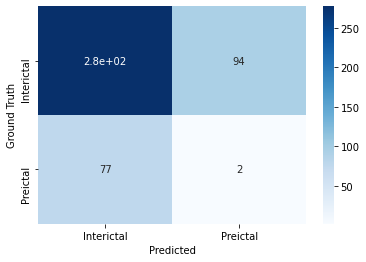

In [204]:
svc = SVC(kernel='sigmoid')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
confuse = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confuse, annot=True, cmap='Blues')
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.show()

[[371   0]
 [ 79   0]]
              precision    recall  f1-score   support

        -1.0       0.82      1.00      0.90       371
         1.0       0.00      0.00      0.00        79

    accuracy                           0.82       450
   macro avg       0.41      0.50      0.45       450
weighted avg       0.68      0.82      0.75       450



/Users/sameenislam/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


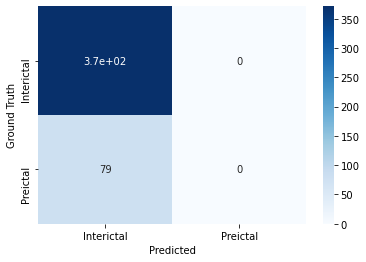

In [205]:
logit = LogisticRegression(random_state=42)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
confuse = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confuse, annot=True, cmap='Blues')
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.show()

So far, it seems the rbf kernel SVM has the best performance as it predicted the most amount of preictals correctly. SVM with polynomial kernel has the lowest false positive (i.e. predicted preictal, truth interictal).

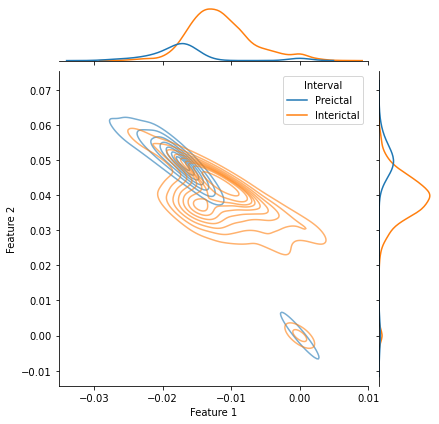

In [128]:
# example kde plot
sns.jointplot(data=rdf, x='Feature 1', y='Feature 2', hue='Interval', kind='kde', alpha=0.6)

(449,) (449,) (1798,) (1798,)


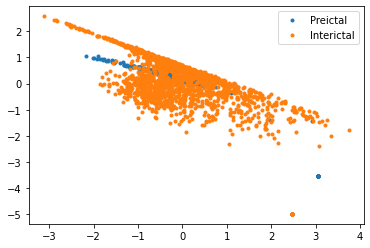

In [215]:
# example on how to use scaler
scaler = StandardScaler()
x1_scaled = scaler.fit_transform(preictal_feature_list[0][:,:,0])[:,0]
x2_scaled = scaler.fit_transform(preictal_feature_list[0][:,:,1])[:,0]
x3_scaled = scaler.fit_transform(interictal_feature_list[0][:,:,0])[:,0]
x4_scaled = scaler.fit_transform(interictal_feature_list[0][:,:,1])[:,0]

print(x1_scaled.shape, x2_scaled.shape, x3_scaled.shape, x4_scaled.shape)


plt.figure()
plt.plot(x1_scaled, x2_scaled, '.', label='Preictal')
plt.plot(x3_scaled, x4_scaled, '.', label='Interictal')
plt.legend()
plt.show()

Classification on normalised data.

In [216]:
scaler = StandardScaler()
preictal_features_scaled = scaler.fit_transform(preictal_feature_list[0][:,0,:])
interictal_features_scaled = scaler.fit_transform(interictal_feature_list[0][:,0,:])
print(preictal_features_scaled.shape, interictal_features_scaled.shape)

(449, 2) (1798, 2)


In [218]:
df = pd.DataFrame(preictal_features_scaled, columns=['Feature 1', 'Feature 2'])
df['Interval'] = 'Preictal'
df_2 = pd.DataFrame(interictal_features_scaled, columns=['Feature 1', 'Feature 2'])
df_2['Interval'] = 'Interictal'
frames = [df, df_2]
rdf = pd.concat(frames)
rdf

,Feature 1,Feature 2,Interval
0,3.054823,-3.549199,Preictal
1,3.054823,-3.549199,Preictal
2,3.054823,-3.549199,Preictal
3,3.054823,-3.549199,Preictal
4,3.054823,-3.549199,Preictal
...,...,...,...
1793,-1.312496,0.375732,Interictal
1794,-0.799553,0.877981,Interictal
1795,-1.228468,1.426397,Interictal
1796,1.223768,-0.516561,Interictal


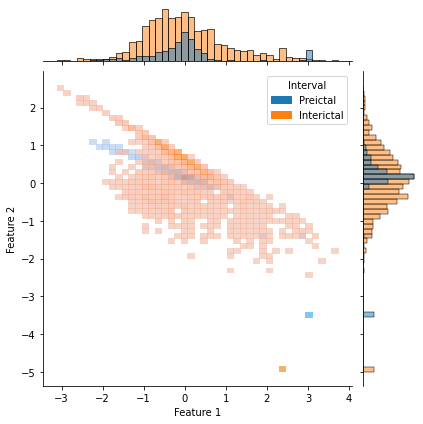

In [219]:
# visualise distribution
sns.jointplot(data=rdf, x='Feature 1', y='Feature 2', hue='Interval', kind='hist', alpha=0.6)
plt.show()

In [220]:
X = np.concatenate((interictal_features_scaled, preictal_features_scaled))

interictal_targets = -1 * np.ones(interictal_features_scaled.shape[0])
preictal_targets = np.ones(preictal_features_scaled.shape[0])
y = np.hstack((interictal_targets, preictal_targets))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

[[367   0]
 [ 83   0]]
              precision    recall  f1-score   support

        -1.0       0.82      1.00      0.90       367
         1.0       0.00      0.00      0.00        83

    accuracy                           0.82       450
   macro avg       0.41      0.50      0.45       450
weighted avg       0.67      0.82      0.73       450



/Users/sameenislam/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


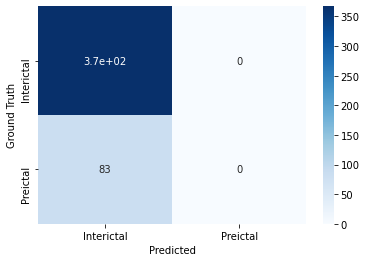

In [221]:
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
confuse = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confuse, annot=True, cmap='Blues')
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.show()

[[366   1]
 [ 69  14]]
              precision    recall  f1-score   support

        -1.0       0.84      1.00      0.91       367
         1.0       0.93      0.17      0.29        83

    accuracy                           0.84       450
   macro avg       0.89      0.58      0.60       450
weighted avg       0.86      0.84      0.80       450



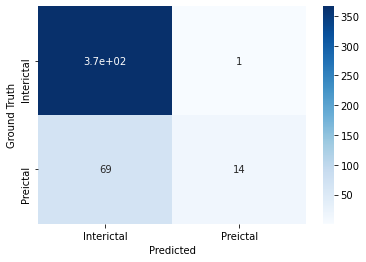

In [222]:
svc = SVC(kernel='rbf')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
confuse = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confuse, annot=True, cmap='Blues')
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.show()

[[367   0]
 [ 75   8]]
              precision    recall  f1-score   support

        -1.0       0.83      1.00      0.91       367
         1.0       1.00      0.10      0.18        83

    accuracy                           0.83       450
   macro avg       0.92      0.55      0.54       450
weighted avg       0.86      0.83      0.77       450



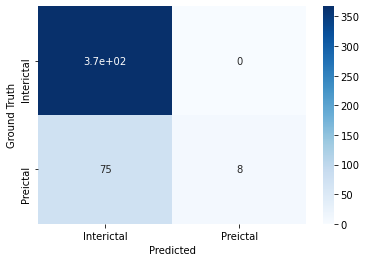

In [223]:
svc = SVC(kernel='poly', degree=3)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
confuse = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confuse, annot=True, cmap='Blues')
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.show()

[[281  86]
 [ 71  12]]
              precision    recall  f1-score   support

        -1.0       0.80      0.77      0.78       367
         1.0       0.12      0.14      0.13        83

    accuracy                           0.65       450
   macro avg       0.46      0.46      0.46       450
weighted avg       0.67      0.65      0.66       450



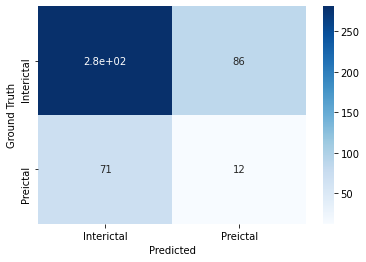

In [224]:
svc = SVC(kernel='sigmoid')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
confuse = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confuse, annot=True, cmap='Blues')
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.show()

[[367   0]
 [ 83   0]]
              precision    recall  f1-score   support

        -1.0       0.82      1.00      0.90       367
         1.0       0.00      0.00      0.00        83

    accuracy                           0.82       450
   macro avg       0.41      0.50      0.45       450
weighted avg       0.67      0.82      0.73       450



/Users/sameenislam/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


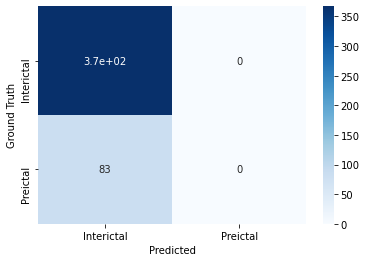

In [225]:
logit = LogisticRegression(random_state=42)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
confuse = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confuse, annot=True, cmap='Blues')
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.show()